# Hierarchical model fit on Splatter datasets

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
import scipy
from utils import loadStan, hierarchical_model, est_k
sns.set()
from sklearn.metrics import adjusted_rand_score
import csv
import math
import time

ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.
Model loaded succesfully from cache.


## Splatter 1 (small and simple)

## Loading data

In [71]:
with open('../Splatter/smallsplat.csv') as file:
    text = csv.reader(file)
    data = np.array(np.array(list(text))[1:,1:].T, dtype=int)
with open('../Splatter/smallsplat_labels.csv') as file:
    text = csv.reader(file)
    labels_raw = np.array(list(text))
    labels = np.unique(labels_raw[1:,1], return_inverse=True)[1]

In [72]:
print(data[:6,:6])
print(labels[:6])

[[ 38   0   3   4  24   2]
 [  8   4   0  17  12   2]
 [ 34   0   2  14  52   2]
 [ 22   0   0  20  43   0]
 [ 25   0   3   8  20   5]
 [ 58   1   8   1 100  15]]
[3 3 0 0 3 1]


In [73]:
ct, ct_count = np.unique(labels, return_counts=True)
for i,j in zip(ct, ct_count):
    print(i,'\t',j)

0 	 95
1 	 116
2 	 88
3 	 98
4 	 103


### Loading/Saving  formatted data

In [74]:
# with open('splat_small.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [2]:
data, labels = pickle.load(open('splat_small.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(500, 400)


## Pre-analysis

### Some explames of distributions of genes

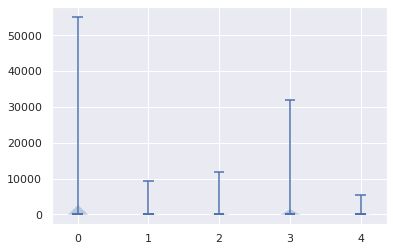

In [76]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]

sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

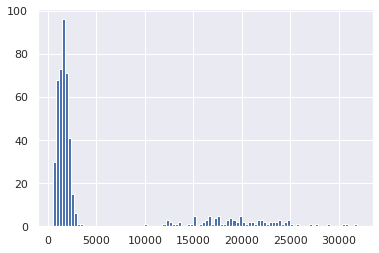

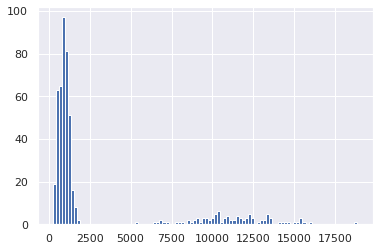

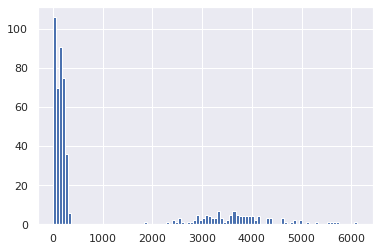

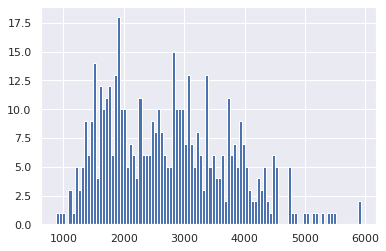

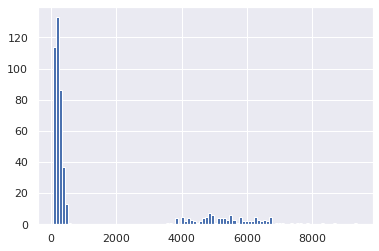

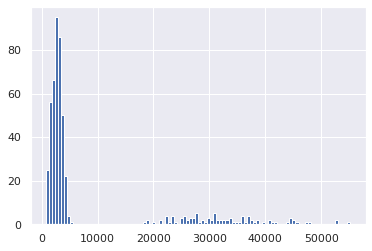

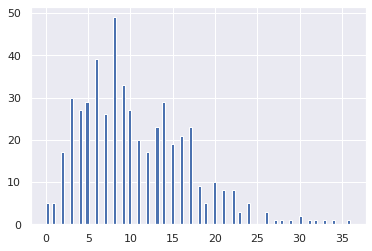

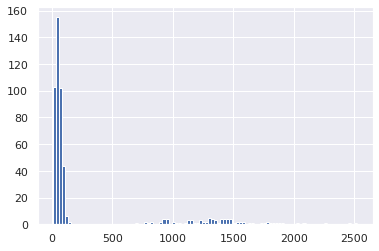

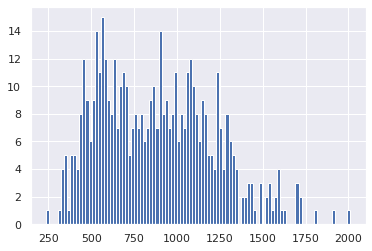

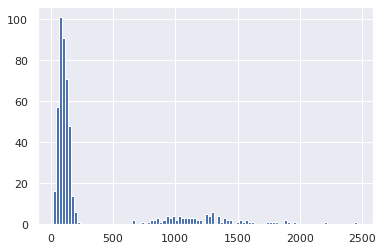

In [77]:
genes = np.random.choice(list(range(D)), p= np.std(data,axis=0)/sum(np.std(data,axis=0)), size=10, replace=False)
for i in range(10):
    plt.hist(data[:,genes[i]], bins=100)
    plt.show()

## Preprocessing

### Transform data

In [3]:
trans_data = np.log2(data+1)

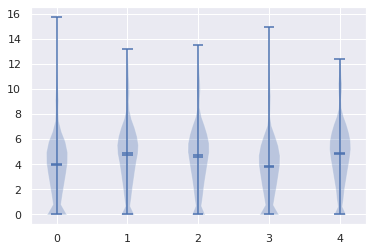

In [79]:
plotdata = [np.concatenate(trans_data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

We remove the genes that are not or barely measured in the dataset to reduce the computational cost.

### Impact of filtering

In [4]:
order = np.argsort(np.std(data, axis=0))
data = data[:,order]

In [5]:
scores = []
rang = np.linspace(0,6,500)
stds = np.std(trans_data, axis=0)
for i in rang:
    scores.append(sum(stds>i))

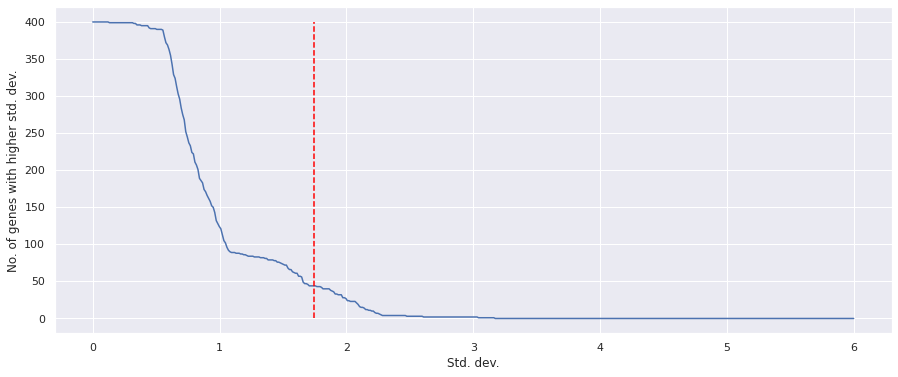

In [25]:
sns.set()
plt.figure(figsize=(15,6))
plt.ylabel('No. of genes with higher std. dev.')
plt.xlabel('Std. dev.')
plt.plot(rang, scores)
plt.plot([rang[145],rang[145]], [0,scores[0]], c = 'red', linestyle='--')
plt.show()

In [6]:
thres = 145
genemask = []
for i in range(D):
    if np.std(trans_data[:,i])>rang[thres]:
        genemask.append(True)
    else:
        genemask.append(False)
genemask = np.array(genemask)
print('Using %i genes with std.dev. of higher than %s'%(int(scores[thres]),str(rang[thres])))

Using 44 genes with std.dev. of higher than 1.7434869739478958


In [7]:
data = trans_data[:,genemask]

In [8]:
np.shape(data)

(500, 44)

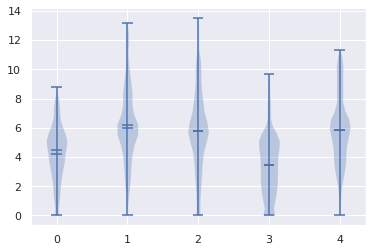

In [9]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

### Loading/Saving  preprocessed data

In [9]:
# with open('smallsplat_prep.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [2]:
data, labels = pickle.load(open('smallsplat_prep.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(500, 44)


### Number of clusters is estimated fairly high

In [104]:
K, _ = est_k(data, k_max = 25, verbose=False, method='bic', refs=3)
print('Estimated number of clusters: ',K)

17  clusters according to AIC,  10  clusters according to BIC.
Estimated number of clusters:  10


### Clear classes can be observed

In [106]:
n_test = 5
labels_test = KMeans(n_test).fit(data).labels_

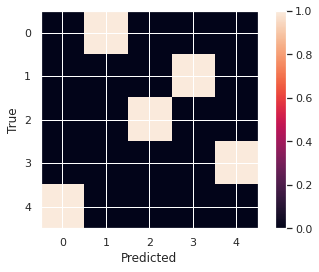

In [107]:
res = np.zeros((5,n_test))
for r in range(5):
    for t in range(n_test):
        res[r,t] = sum(labels[labels_test==t]==r)
    res[r,:] = res[r,:]/sum(res[r,:])
sns.set()
plt.imshow(res, label='Percentage samples')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [108]:
adjusted_rand_score(labels, labels_test)

1.0

## Analysis

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Latent data on top level:


Estimated number of clusters (level 0):  5


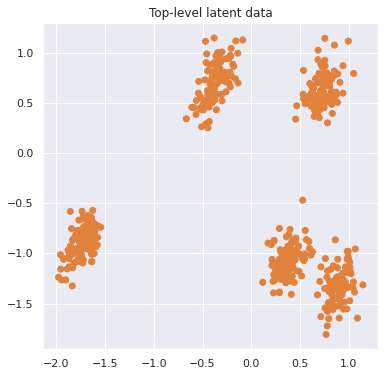

level  1 :
Cluster  1  contains  5  subclusters


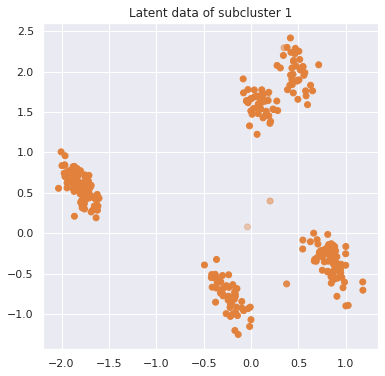

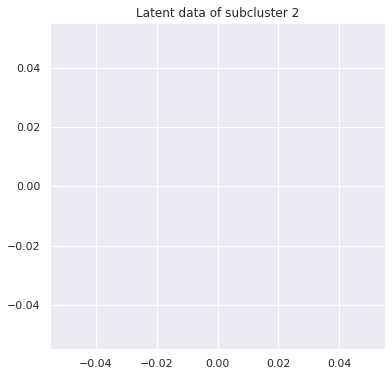

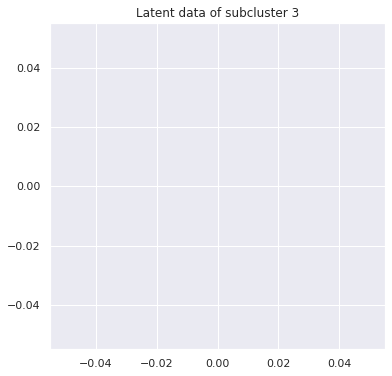

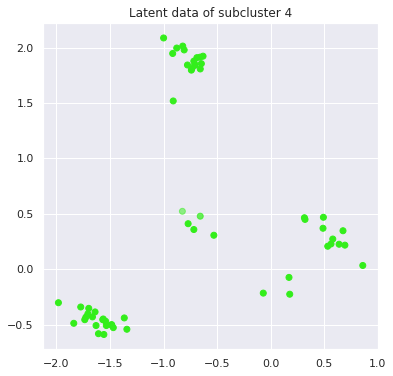

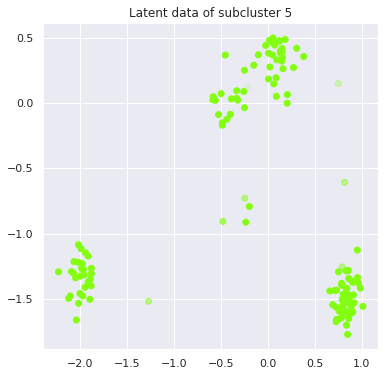

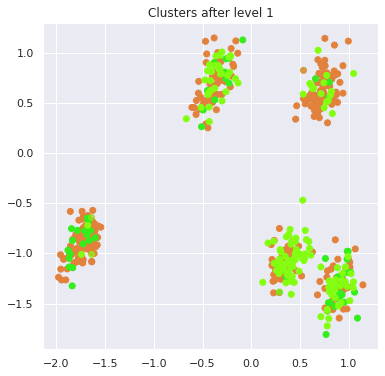

level  2 :
Cluster  1  doesnt contain any more subclusters


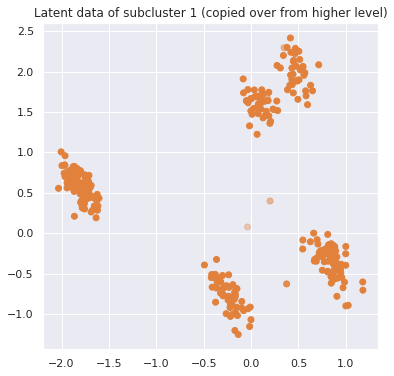

Cluster  2  doesnt contain any more subclusters


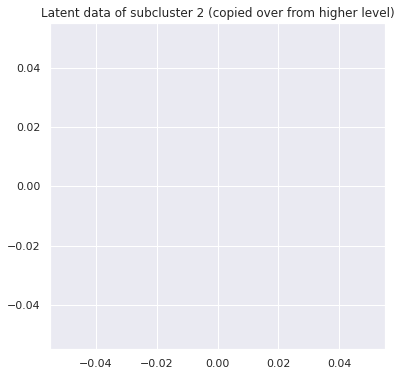

Cluster  3  doesnt contain any more subclusters


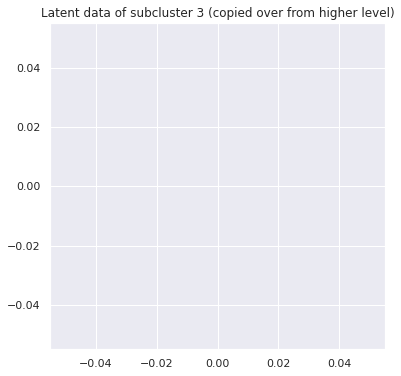

Cluster  4  doesnt contain any more subclusters


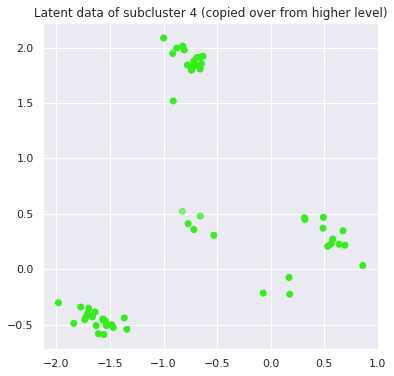

Cluster  5  doesnt contain any more subclusters


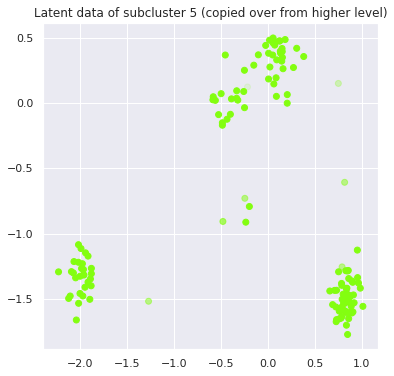

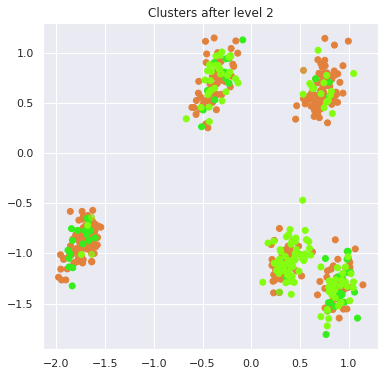

All clusters are fully analyzed!


In [5]:
model = hierarchical_model()
latent, cats_per_lvl, probs = model.fit(data, max_depth=5, k_max=5)

In [10]:
import pandas as pd

In [6]:
model_test = pickle.load(open('smallsplat_vb.pkl', 'rb'))

In [11]:
df = pd.read_csv(model_test['args']['sample_file'].decode('ascii'), comment='#').dropna()

In [52]:
dfmean = df.iloc[423]

In [53]:
### dfmean = df.mean()
dfz = dfmean[dfmean.index.str.startswith('z.')]
cur_latent = np.array(dfz).reshape(N, 2,3).T
dfclus = dfmean[dfmean.index.str.startswith('clusters.')]
rawprobs = np.array(dfclus).reshape(3,N).T

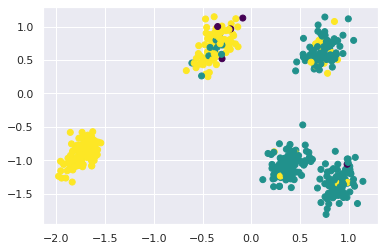

In [54]:
plt.scatter(model.latent[0][0][0,:],model.latent[0][0][1,:], c=np.argmax(rawprobs,axis=1), cmap='viridis')
plt.show()

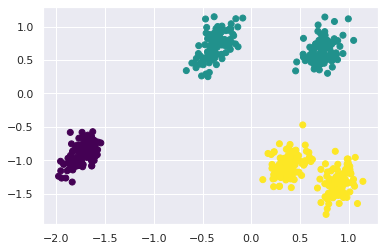

In [55]:
plt.scatter(model.latent[0][0][0,:],model.latent[0][0][1,:], c=KMeans(3).fit(data).labels_, cmap='viridis')
plt.show()

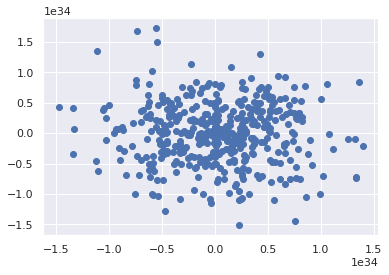

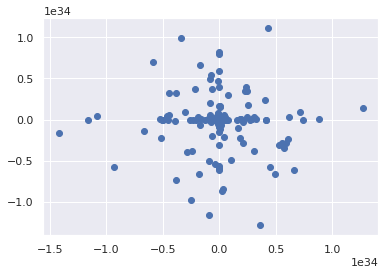

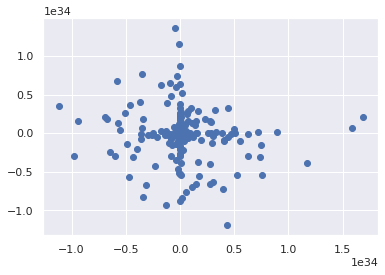

In [21]:
for i in cur_latent:
    plt.scatter(i[0,:], i[1,:])
    plt.show()

In [49]:
x = data
M=2
max_depth=5
k_max = 2
plotting=True
min_clus_size=10
vis_threshold=0.05
gmm = False
its=300
samplingmethod='vb'

latent = [[]]
mus = [[]]
cats_per_lvl = []

In [50]:
# initialize the algorithm

if M>3 and plotting:
    print('Latent dimensions greater than 3, plotting only the three most important dimensions.')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')

N,D = np.shape(x)
N
probs = [np.ones(N)[np.newaxis].T]
colors = [np.random.uniform(size=3) for k in range(k_max**max_depth)]

if gmm:
    est_ref = 1
else:
    est_ref = 2

# top-level latent data
print('Latent data on top level:')
ppca_dat = {'N':N, 'M':M, 'D':D, 'x':x, 'weights': probs[-1][:,0]}
if samplingmethod == 'vb':
    fit = ppca_weighted.vb(data=ppca_dat)
    df = pd.read_csv(fit['args']['sample_file'].decode('ascii'), comment='#').dropna()
    dfmean = df.mean()
    dfz = dfmean[dfmean.index.str.startswith('z.')]
    latent_top = np.array(dfz).reshape(N, M).T
elif samplingmethod == 'NUTS':
    fit_top = ppca_weighted.sampling(data=ppca_dat, iter=its, chains=1)
    fitreturn_top = fit_top.extract()
    best_ind_top = np.where(fitreturn_top['lp__']==max(fitreturn_top['lp__']))[0][0]
    latent_top = fitreturn_top['z'][best_ind_top]
else:
    print("Please use 'NUTS' or 'vb' as samplingmethod!")
    

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Latent data on top level:


Estimated number of clusters (level 0):  2


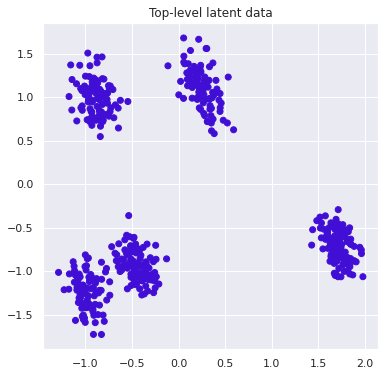

In [51]:
latent[-1].append(latent_top)

# top-level cluster determination
K_1, clusters_1 = est_k(x, k_max = k_max, gmm = gmm, refs = est_ref)
mus[-1].append(clusters_1['mu'])
print('Estimated number of clusters (level 0): ', K_1)

# in case M>3, find out which three dimensions to plot in 3D
if M>2:
    chosen = []
    for dim in range(3):
        s = 0
        for i in range(M):
            if i not in chosen:
                if np.std(latent[0][0][i,:])>s:
                    s = np.std(latent[0][0][i,:])
                    best = i
        chosen.append(best)
    dimx,dimy,dimz = chosen

# plot top-level latent data with coloured first clusters
if plotting:
    rgba_colors = np.zeros((N,4))
#             for k_i in range(K_1):
    rgba_colors[:,:3] = colors[0]
    rgba_colors[:,3] = 1.0
    fig = plt.figure(figsize=(6,6))
    if M==2:
        ax = fig.add_subplot(111)
        plt.scatter(latent[-1][0][0,:],latent[-1][0][1,:], c = rgba_colors)
    if M>2:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(latent[-1][0][dimx,:],latent[-1][0][dimy,:],latent[-1][0][dimz,:], c = rgba_colors)
    ax.set_title('Top-level latent data')
    plt.show()

cats = np.argmax(probs[-1],axis=1)
cats_per_lvl.append(cats.copy())

level  1 :
Cluster  1  contains  2  subclusters


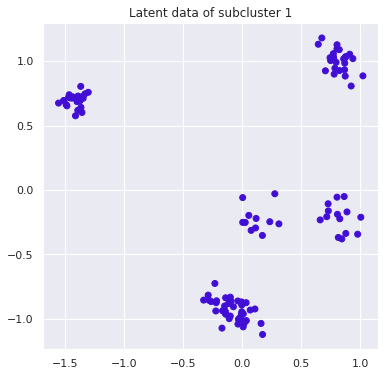

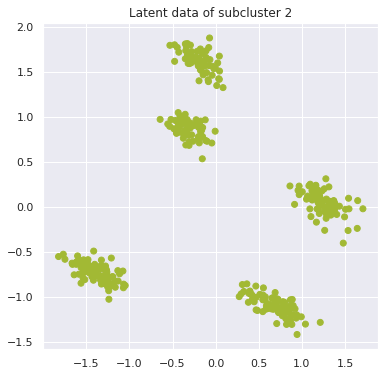

level  2 :
Cluster  1  doesnt contain any more subclusters


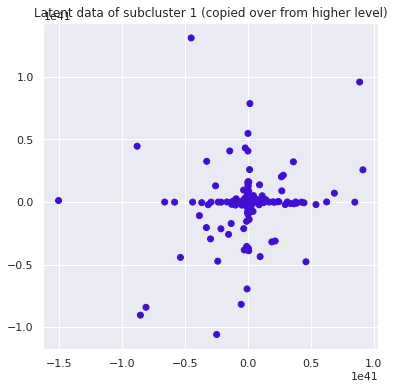

level  3 :
Cluster  1  doesnt contain any more subclusters


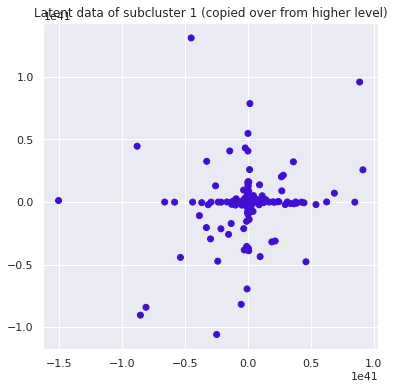

level  4 :
Cluster  1  doesnt contain any more subclusters


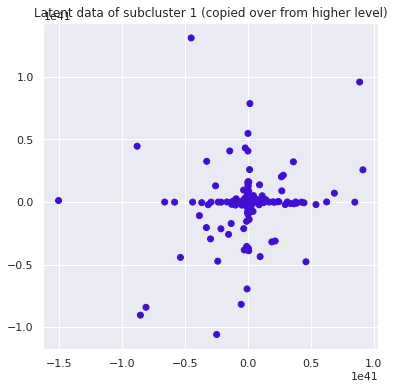

level  5 :
Cluster  1  doesnt contain any more subclusters


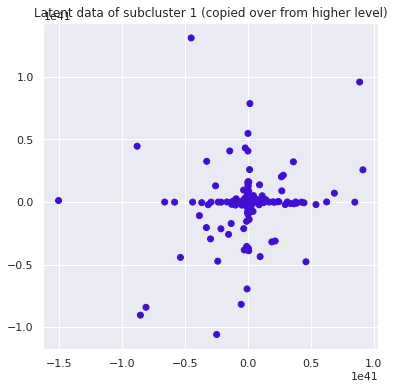

In [52]:
for lvl in range(max_depth):
    # repeat cluster detemination and MoPPCAs until max_depth is reached or until all clusters fully analyzed
    more_depth = False
    print('level ', lvl+1, ':')
    cur_probs = probs[-1].copy()
    # probability matrix of clusters is sometimes transposed
    if np.shape(cur_probs)[1]==N:
        cur_probs = cur_probs.T
    n_clus = np.shape(cur_probs)[1]
    count = 0
    latent.append([])

    # analyze all subclusters as found in the last level
    for cl in range(n_clus):

        clus_probs = cur_probs[:,cl]

        # Dont divide clusters further if they are too small
        if sum(cats==cl)>k_max:
            n_subs, subs = est_k(x[cats==cl], k_max = k_max, gmm = gmm, refs = est_ref, weights=cur_probs)
            while np.any([sum(subs['labels']==k_i)<min_clus_size for k_i in range(n_subs)]):
                if n_subs <= 2:
                    n_subs = 1
                    break
                n_subs, subs = est_k(x[cats==cl], k_max = n_subs-1, gmm = gmm, refs = est_ref, weights=cur_probs)
        else:
            n_subs = 1

        if n_subs == 1:
            # If cluster doesnt contain more subclusters, just copy it over to the next level
            print('Cluster ', cl+1, ' doesnt contain any more subclusters')
            new_probs = clus_probs[np.newaxis].T
            cur_latent = latent[-2][cl]
            latent[-1].append(cur_latent)
            mask = clus_probs>vis_threshold
            # And plot if chosen so
            if plotting:
                rgba_colors = np.zeros((sum(mask),4))
                rgba_colors[:,:3] = colors[count]
                rgba_colors[:,3] = new_probs[mask,0]
                fig = plt.figure(figsize=(6,6))
                if M==2:
                    ax = fig.add_subplot(111)
                    ax.scatter(cur_latent[0,mask], cur_latent[1,mask], c=rgba_colors)
                if M>2:
                    ax = fig.add_subplot(111, projection='3d')
                    ax.scatter(cur_latent[dimx,mask], cur_latent[dimy,mask], cur_latent[dimz,mask], c=rgba_colors)
                ax.set_title('Latent data of subcluster '+str(cl+1)+' (copied over from higher level)')
                plt.show()
            count+=1
        else:
            # If cluster contains more subclusters, initiate MoPPCAs
            more_depth = True
            print('Cluster ', cl+1, ' contains ',n_subs,' subclusters')
#                     try:
            moppcas_dat = {'N':N, 'M':M,'K':n_subs, 'D':D, 'y':x, 'weights':clus_probs}
            if samplingmethod == 'vb':
                fit = moppcas_weighted.vb(data=moppcas_dat, init=[{'mu':subs['mu'], 'theta':subs['theta'], 'z':[np.zeros((M,N)) for i in range(n_subs)]}])
                df = pd.read_csv(fit['args']['sample_file'].decode('ascii'), comment='#').dropna()
                dfmean = df.mean()
                dfz = dfmean[dfmean.index.str.startswith('z.')]
                cur_latent = np.array(dfz).reshape(N, M, n_subs).T
                dfclus = dfmean[dfmean.index.str.startswith('clusters.')]
                rawprobs = np.array(dfclus).reshape(n_subs,N).T
            elif samplingmethod == 'NUTS':
                fit = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=its, init=[{'mu':subs['mu'],
                                                                                             'z':[np.zeros((M,N)) for i in range(n_subs)]}])
                fit_ext_molv1 = fit.extract()
                best_molv1 = np.where(fit_ext_molv1['lp__']==max(fit_ext_molv1['lp__']))[0][0]
                cur_latent = fit_ext_molv1['z'][best_molv1]
                rawprobs = np.mean(fit_ext_molv1['clusters'],axis=0).T
            else:
                print("Please use 'NUTS' or 'vb' as samplingmethod!")
                


            new_probs = (rawprobs*clus_probs[np.newaxis].T).T
            plotcats = np.argmax(new_probs, axis=1)

            # and plot latent data of all newfound subclusters if chosen so

            for i,l in enumerate(cur_latent):
                    plotprobs = new_probs[i,:]
                    mask = plotprobs>vis_threshold
                    latent[-1].append(l)
                    if plotting:
                        rgba_colors = np.zeros((sum(mask),4))
            #                             n_subs, subs = est_k(x[mask], k_max = k_max)
            #                             for k_i in range(n_subs):
                        rgba_colors[:,:3] = colors[count]
                        count+=1
                        rgba_colors[:,3] = plotprobs[mask]
                        fig = plt.figure(figsize=(6,6))
                        if M==2:
                            ax = fig.add_subplot(111)
                            ax.scatter(l[0,mask],l[1,mask], c=rgba_colors)
                        if M>2:
                            ax = fig.add_subplot(111, projection='3d')
                            ax.scatter(l[dimx,mask],l[dimy,mask], l[dimz,mask], c=rgba_colors)
                        ax.set_title('Latent data of subcluster '+str(i+1))
                        plt.show()
            if cl==0:
                probs_round = new_probs
            else:
                probs_round = np.hstack((probs_round, new_probs))

            cats = np.argmax(probs_round,axis=1)

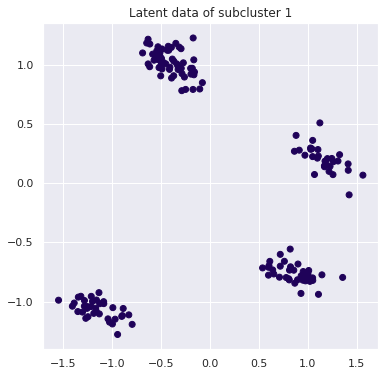

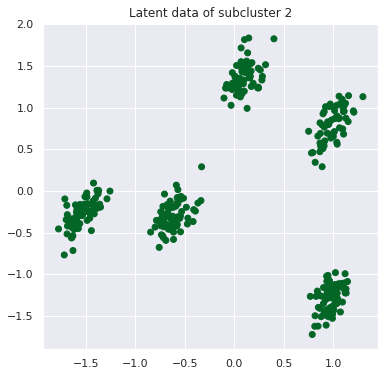

In [30]:
for i,l in enumerate(cur_latent):
        plotprobs = new_probs[i,:]
        mask = plotprobs>vis_threshold
        latent[-1].append(l)
        if plotting:
            rgba_colors = np.zeros((sum(mask),4))
#                             n_subs, subs = est_k(x[mask], k_max = k_max)
#                             for k_i in range(n_subs):
            rgba_colors[:,:3] = colors[count]
            count+=1
            rgba_colors[:,3] = plotprobs[mask]
            fig = plt.figure(figsize=(6,6))
            if M==2:
                ax = fig.add_subplot(111)
                ax.scatter(l[0,mask],l[1,mask], c=rgba_colors)
            if M>2:
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(l[dimx,mask],l[dimy,mask], l[dimz,mask], c=rgba_colors)
            ax.set_title('Latent data of subcluster '+str(i+1))
            plt.show()
if cl==0:
    probs_round = new_probs
else:
    probs_round = np.hstack((probs_round, new_probs))

cats = np.argmax(probs_round,axis=1)

In [67]:
probs

[array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

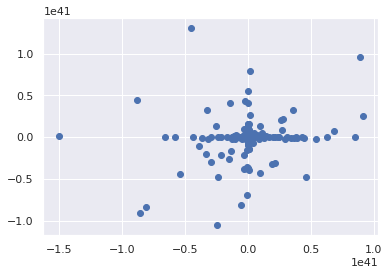

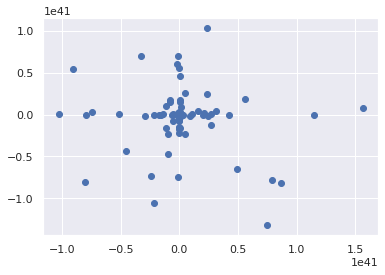

In [63]:
for l in latent[1]:
    plt.scatter(l.T[:,0], l.T[:,1])
    plt.show()

In [40]:
np.shape(probs_round[0,:])

(500,)

In [35]:
probs_round[:,c]

array([1.00000000e+000, 1.00228771e-123])

In [36]:
c

2

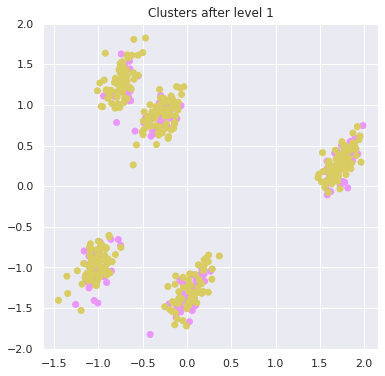

In [42]:
# Plotting Top-level latent data with new cluster-colouring
fig = plt.figure(figsize=(6,6))
if M==2:
    ax = fig.add_subplot(111)
if M>2:
    ax = fig.add_subplot(111, projection='3d')
for c in range(np.shape(probs_round)[0]):
    mask = probs_round[c,:]>vis_threshold
    rgba_colors = np.zeros((sum(mask),4))
    rgba_colors[:,:3] = colors[c]
    rgba_colors[:,3] = probs_round[c,:][mask]
    if M==2:
        ax.scatter(latent[0][0][0,mask],latent[0][0][1,mask], c = rgba_colors)
    if M>2:
        ax.scatter(latent[0][0][dimx,mask],latent[0][0][dimy,mask],latent[0][0][dimz,mask], c = rgba_colors)
ax.set_title('Clusters after level '+str(lvl+1))
plt.show()

# Stop if all clusters are fully analyzed
if more_depth == False:
    print('All clusters are fully analyzed!')


probs.append(probs_round.copy())
cats_per_lvl.append(cats.copy())

In [ ]:
def visualize_tree(self,categories = None, vis_threshold=0.05):
    # plot the subdivision of clusters in hierarchical order
    if np.all(categories)==None:
        categories = self.cats_per_lvl[-1]
    for lvl in range(len(self.latent)):
        print('Level ', lvl)
        n_lat = len(self.latent[lvl])
        fig = plt.figure(figsize=(min(n_lat*6, 24), (int((n_lat-1)/4)+1)*6))
        for lat in range(n_lat):
            rgba_colors = np.zeros((self.N, 4))
            for k_i in range(int(max(categories))):
                rgba_colors[categories==k_i,:3] = self.colors[k_i]
            if np.shape(self.probs[lvl])[0]==self.N:
                n_cat = np.shape(self.probs[lvl])[1]
                prob_cur = self.probs[lvl]
            else:
                n_cat = np.shape(self.probs[lvl])[0]
                prob_cur = self.probs[lvl].T
            for k_i in range(n_cat):
                rgba_colors[:,3] = prob_cur[:,lat]
            vis_mask = np.array(prob_cur[:,lat]>vis_threshold)
            if self.M==2:
                ax = fig.add_subplot(int((n_lat-1)/4)+1, min(n_lat, 4), lat+1)
                ax.scatter(self.latent[lvl][lat][0,vis_mask],self.latent[lvl][lat][1,vis_mask],c = rgba_colors[vis_mask,:])
            if self.M>2:
                ax = fig.add_subplot(int((n_lat-1)/4)+1, min(n_lat, 4), lat, projection='3d')
                ax.scatter(self.latent[lvl][lat][self.dimx,vis_mask],self.latent[lvl][lat][self.dimy,vis_mask],self.latent[lvl][lat][self.dimz,vis_mask],c = rgba_colors[vis_mask,:])
        plt.suptitle('Clusters on level '+str(lvl))
        plt.show()
    return

def visualize_end(self,categories = None, vis_threshold=0.05):
    # plot the top-level latent data with the end-result of the clustering as colouring
    if np.all(categories)==None:
        categories = self.cats_per_lvl[-1]
        title = 'Top-level latent data coloured by guessed clusters'
    else:
        title = 'Top-level latent data coloured by given clusters'
    rgba_colors = np.ones((self.N, 4))
    for k_i in range(int(max(categories))):
        rgba_colors[categories==k_i,:3] = self.colors[k_i]
#             rgba_colors[categories==k_i,3] = self.probs[-1][categories==k_i,k_i]
    fig = plt.figure(figsize=(6,6))
    if self.M==2:
#             print('Plotting 2-dimensional latent data with final cluster colouring.')
        ax = fig.add_subplot(111)
        ax.scatter(self.latent[0][0][0,:],self.latent[0][0][1,:],c = rgba_colors)
    if self.M>2:
#             print('Plotting 3-dimensional latent data with final cluster colouring.')
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.latent[0][0][self.dimx,:],self.latent[0][0][self.dimy,:],self.latent[0][0][self.dimz,:],c = rgba_colors)
    ax.set_title(title)
    plt.show()
    return

def visualize_latent_final(self, categories=None, vis_threshold=0.05):
    # plot the latent spaces of all found subclusters
    if np.all(categories)==None:
        title = 'Latent data coloured by guessed clusters'
        categories = self.cats_per_lvl[-1]
    else:
        title = 'Latent data coloured by given clusters'
    n_lat = len(self.latent[-1])
    fig = plt.figure(figsize=(min(n_lat*6, 24), (int((n_lat-1)/4)+1)*6))
    for lat in range(n_lat):
        rgba_colors = np.zeros((self.N, 4))
        for k_i in range(int(max(categories))):
            rgba_colors[categories==k_i,:3] = self.colors[k_i]
        if np.shape(self.probs[-1])[0]==self.N:
            n_cat = np.shape(self.probs[-1])[1]
            prob_cur = self.probs[-1]
        else:
            n_cat = np.shape(self.probs[-1])[0]
            prob_cur = self.probs[-1].T
        for k_i in range(n_cat):
            rgba_colors[:,3] = prob_cur[:,lat]
        vis_mask = np.array(prob_cur[:,lat]>vis_threshold)
        if self.M==2:
            ax = fig.add_subplot(int((n_lat-1)/4)+1, min(n_lat, 4), lat+1)
            ax.scatter(self.latent[-1][lat][0,vis_mask],self.latent[-1][lat][1,vis_mask],c = rgba_colors[vis_mask,:])
        if self.M>2:
            ax = fig.add_subplot(int((n_lat-1)/4)+1, min(n_lat, 4), lat, projection='3d')
            ax.scatter(self.latent[-1][lat][self.dimx,vis_mask],self.latent[-1][lat][self.dimy,vis_mask],self.latent[-1][lat][self.dimz,vis_mask],c = rgba_colors[vis_mask,:])
    plt.suptitle(title)
    plt.show()
    return

def ari_per_level(self, ind):
    lvls = len(self.cats_per_lvl)
    return [adjusted_rand_score(self.cats_per_lvl[lvl], ind) for lvl in range(lvls)]

def visual_score(self, ind, plot_hmppca = True, plot_hmppca_logres = False, plot_real = True, plot_logreg = True):
    for lvl in range(len(self.latent)):

        lvl_i = min(len(self.latent)-1, lvl+1)

        if plot_hmppca:

            nclus = len(self.latent[lvl])
            print('level ', lvl)
            fig = plt.figure(figsize=(min(nclus*4, 24),5*(int(nclus/6)+1)))
            for clus in range(nclus):
                ax = fig.add_subplot(int(nclus/6)+1,min(nclus,6),clus+1)
                mask = self.probs[lvl][:,clus]>0.1
                rgba_cols = np.zeros((N,4))
                for k_i in set(self.cats_per_lvl[lvl_i][np.argmax(self.probs[lvl],axis=1)==clus]):
                    rgba_cols[self.cats_per_lvl[lvl_i]==k_i,:3] = self.colors[k_i]
                    rgba_cols[self.cats_per_lvl[lvl_i]==k_i,3] = self.probs[lvl][self.cats_per_lvl[lvl_i]==k_i,clus]
                    if lvl<len(self.latent)-1:
                        cc_x, cc_y = np.average(self.latent[lvl][clus], axis=1, weights = self.probs[lvl_i][:,k_i])
                        plt.scatter(cc_x, cc_y, s = 500, c = 'black', zorder=9)
                        plt.text(cc_x, cc_y, str(k_i+1),fontweight= 'bold', size=14, c = 'white', zorder=10,horizontalalignment='center',
            verticalalignment='center')
                ax.scatter(self.latent[lvl][clus][0,:][mask],self.latent[lvl][clus][1,:][mask], c=rgba_cols[mask,:], zorder=1)
                ax.set_title('subcluster '+str(clus+1))
            plt.suptitle('HmPPCA clusters')
            plt.show()


        if plot_hmppca_logres:
            fig = plt.figure(figsize=(min(nclus*4, 24),5*(int(nclus/6)+1)))
            c_i = 0
            for clus in range(len(self.latent[lvl])):

                classifier = sklearn.linear_model.SGDClassifier(loss='log')
                classifier.fit(self.latent[lvl][clus].T, self.cats_per_lvl[lvl_i], sample_weight=self.probs[lvl][:,clus])
                preds = classifier.predict(self.latent[lvl][clus].T)
                preds = np.unique(preds, return_inverse=True)[1]

                ax = fig.add_subplot(int(nclus/6)+1,min(nclus,6),clus+1)
                mask = self.probs[lvl][:,clus]>0.1
                rgba_cols = np.ones((N,4))

                for k_i in range(len(set(preds))):
                    rgba_cols[preds==k_i,:3] = self.colors[c_i]
                    c_i+=1

                ax.scatter(self.latent[lvl][clus][0,:][mask],self.latent[lvl][clus][1,:][mask], c=rgba_cols[mask,:])
            plt.suptitle('log.reg. clusters (based on hmppca)')
            plt.show()

        if plot_real:
            fig = plt.figure(figsize=(min(nclus*4, 24),5*(int(nclus/6)+1)))
            for clus in range(len(self.latent[lvl])):
                ax = fig.add_subplot(int(nclus/6)+1,min(nclus,6),clus+1)
                mask = self.probs[lvl][:,clus]>0.1
                rgba_cols = np.ones((N,4))
                for k_i in range(len(set(ind))):
                    rgba_cols[ind==k_i,:] = self.colors[k_i]
                ax.scatter(self.latent[lvl][clus][0,:][mask],self.latent[lvl][clus][1,:][mask], c=rgba_cols[mask,:])
            plt.suptitle('Real clusters')
            plt.show()

        if plot_logreg:
            fig = plt.figure(figsize=(min(nclus*4, 24),5*(int(nclus/6)+1)))
            c_i = 0
            w_ARI = 0
            w_ACC = 0
            for clus in range(len(self.latent[lvl])):

                classifier = sklearn.linear_model.SGDClassifier(loss='log')
                classifier.fit(self.latent[lvl][clus].T, ind, sample_weight=self.probs[lvl][:,clus])
                preds = classifier.predict(self.latent[lvl][clus].T)

                ax = fig.add_subplot(int(nclus/6)+1,min(nclus,6),clus+1)
                mask = self.probs[lvl][:,clus]>0.1
                rgba_cols = np.zeros((N,4))

                for k_i in set(preds):
                    rgba_cols[preds==k_i,:] = cols[int(k_i)]
                    c_i+=1
                rgba_cols[:,3] = np.ones(N)
                ax.scatter(model.latent[lvl][clus][0,:][mask],self.latent[lvl][clus][1,:][mask], c=rgba_cols[mask,:])
                ari = adjusted_rand_score(preds[mask], ind[mask])
                acc = accuracy_score(preds, ind, sample_weight = self.probs[lvl][:,clus])
                ax.set_title('Cluster %i - ARI: %.3f, ACC: %.3f'%(clus+1,ari,acc))
                w_ARI+= ari*(sum(mask))/N
                w_ACC+= acc*(sum(mask))/N
            plt.suptitle('log.reg. - w. ARI: %.3f, w. ACC: %.3f'%(w_ARI, w_ACC))
            plt.show()

In [10]:
ppca_ard = loadStan('ppca_ard', recompile=True)
ppca_dat = {'N':N,'M':N-1,'D':D,'x':data}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_52381caf3d94a75b8caf75fed72e83e9 NOW.


Model compiled succesfully.
Model saved succesfully to cache.


In [ ]:
fit = ppca_ard.vb(data=ppca_dat)

In [ ]:
ppca_dat = {'N':N,'M':M,'D':D,'x':data, 'weights':np.ones(N)}
fit = ppca_weighted.vb(data=ppca_dat)

In [32]:
df = pd.read_csv(fit['args']['sample_file'].decode('ascii'), comment='#').dropna()
dfmean = df.mean()
dfz = dfmean[dfmean.index.str.startswith('z.')]
latent_top = np.array(dfz).reshape(N, M)

In [34]:
latent_top.T

array([[ 0.90992015,  0.54638504],
       [ 0.95669588,  0.58680453],
       [ 0.64896663, -0.63865863],
       [ 0.73236665, -0.68889293],
       [ 0.84942712,  0.50082222],
       [-1.67636142, -1.47133193],
       [-0.89700658,  1.330035  ],
       [-0.70383619,  0.58803065],
       [-1.13267181,  1.1842583 ],
       [-0.99406689,  0.7396956 ],
       [-1.43286243, -1.38565208],
       [-1.26675386,  1.19186216],
       [-1.44789819, -1.59557655],
       [ 0.7670681 , -0.41668494],
       [-1.1113004 ,  1.25096704],
       [-0.72494945,  0.580005  ],
       [ 0.78815275,  0.69352088],
       [-1.01381327,  1.21838568],
       [-0.98836645, -1.46538263],
       [ 0.54053482,  0.62151196],
       [-0.85803673,  0.69257132],
       [ 0.62969271, -0.63063206],
       [ 0.68518411, -0.53828501],
       [-1.22692314,  1.36181457],
       [-0.76691681,  0.64294261],
       [-0.71288483,  1.08984969],
       [-1.12474936,  1.32514672],
       [ 1.00508854,  0.60468728],
       [-1.35464825,

In [31]:
dfz

z.1.1      0.909920
z.2.1      0.546385
z.1.2      0.956696
z.2.2      0.586805
z.1.3      0.648967
             ...   
z.2.498    1.376381
z.1.499    0.561793
z.2.499   -0.610231
z.1.500   -1.201355
z.2.500   -1.482904
Length: 1000, dtype: float64

In [3]:
k_test = 3
N,D = np.shape(data)
M = 2
moppcas_dat = {'N':N, 'M':M,'K':k_test, 'D':D, 'y':data, 'weights':np.ones(N)}

In [4]:
kmns = KMeans(k_test).fit(data)

In [5]:
info2 = moppcas_weighted.vb(data=moppcas_dat, init={'mu':kmns.cluster_centers_,'theta':[sum(kmns.labels_==i)/N for i in range(k_test)],
                                                                            'z':[np.zeros((2,N)) for i in range(k_test)],
                                                                             'sigma':np.ones(k_test)})

In [6]:
with open('smallsplat_vb.pkl', 'wb') as f:
    pickle.dump(info2, f)

In [9]:
info = moppcas_weighted.vb(data=moppcas_dat, init={'mu':kmns.cluster_centers_,'z':[np.zeros((2,N)) for i in range(k_test)]})

RuntimeError: stan::variational::normal_meanfield::calc_grad: The number of dropped evaluations has reached its maximum amount (10). Your model may be either severely ill-conditioned or misspecified.

In [7]:
info3 = moppcas_weighted.vb(data=moppcas_dat, init={'mu':kmns.cluster_centers_})

RuntimeError: stan::variational::normal_meanfield::calc_grad: The number of dropped evaluations has reached its maximum amount (10). Your model may be either severely ill-conditioned or misspecified.

In [6]:
info2 = moppcas_weighted.vb(data=moppcas_dat, init={'mu':kmns.cluster_centers_,'theta':[sum(kmns.labels_==i)/N for i in range(k_test)],
                                                                            'z':[np.zeros((2,N)) for i in range(k_test)]})

RuntimeError: stan::variational::advi::calc_ELBO: The number of dropped evaluations has reached its maximum amount (100). Your model may be either severely ill-conditioned or misspecified.

In [14]:
import pandas as pd
df = pd.read_csv(info['args']['sample_file'].decode('ascii'), comment='#').dropna()
# best = df.iloc[0]

scores = list(df['log_p__'])
scores.sort(reverse=True)
best = df[df['log_p__']==scores[1]].iloc[0]

In [21]:
dfmean = df.mean()

In [23]:
mu_vb = dfmean[dfmean.index.str.startswith('mu.')]
mu_found = np.array(mu_vb).reshape(k_test,D)

In [69]:
dfz = dfmean[dfmean.index.str.startswith('z.')]
zfound = np.array(dfz).reshape(N, M, k_test).T

In [70]:
dfz

z.1.1.1      3.107967e+33
z.2.1.1      5.193687e-01
z.3.1.1      5.721064e+32
z.1.2.1      2.489832e+33
z.2.2.1     -9.717900e-01
                 ...     
z.2.1.500    5.814748e+30
z.3.1.500    1.562818e-01
z.1.2.500    1.036441e+33
z.2.2.500    7.597395e+30
z.3.2.500    5.251886e-02
Length: 3000, dtype: float64

In [55]:
dfclus = dfmean[dfmean.index.str.startswith('clusters.')]

In [68]:
clus_found = np.array(dfclus).reshape(k_test,N).T

array([[9.79588412e-04, 9.99020411e-01, 0.00000000e+00],
       [1.32983017e-07, 9.99999867e-01, 0.00000000e+00],
       [7.50408591e-11, 1.00000000e+00, 0.00000000e+00],
       ...,
       [1.98487512e-55, 1.00000000e+00, 0.00000000e+00],
       [2.86283716e-12, 1.00000000e+00, 0.00000000e+00],
       [3.24711289e-67, 2.26159840e-70, 1.00000000e+00]])

In [ ]:
mu_sim = float(best['mu'])
y_sim_vb = np.array(best[best.index.str.startswith('y_mis')])
sigma_sim = float(best['sigma'])

print('First missing values: ', y_sim_vb[:6])
print('Guessed mean: ', np.mean(y_sim_vb))
print('Mean of the filled in missing data: ', mu_sim)
print('Guessed standard deviation: ', sigma_sim)
print('Standard deviation of the filled in missing data: ', np.std(y_sim_vb))

In [16]:
fit = moppcas_weighted.sampling(data=moppcas_dat, chains=1,iter=500,init=[{'mu':kmns.cluster_centers_,'theta':[sum(kmns.labels_==i)/N for i in range(k_test)],
                                                                            'z':[np.zeros((2,N)) for i in range(k_test)],
                                                                             'sigma':np.ones(k_test)}])

RuntimeError: Initialization failed.

In [ ]:
fit2 = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=500, init=[{'mu':kmns.cluster_centers_, 'theta':[sum(kmns.labels_==i)/N for i in range(2)],
                                                                            'z':[np.zeros((2,N)) for i in range(2)]}])

In [ ]:
fit3 = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=500, init=[{'mu':kmns.cluster_centers_,'theta':[sum(kmns.labels_==i)/N for i in range(2)]}])

In [ ]:
fit4 = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=500, init=[{'mu':kmns.cluster_centers_}])

In [ ]:
fit5 = moppcas_weighted.sampling(data=moppcas_dat, chains=1, iter=500, init=[{'mu':kmns.cluster_centers_,'z':[np.zeros((2,N)) for i in range(2)]}])

## Splatter 2 (Larger and more complex)

## Loading data

In [44]:
with open('../Splatter/bigsplat.csv') as file:
    text = csv.reader(file)
    data = np.array(np.array(list(text))[1:,1:].T, dtype=int)
with open('../Splatter/bigsplat_labels.csv') as file:
    text = csv.reader(file)
    labels_raw = np.array(list(text))
    labels = np.unique(labels_raw[1:,1], return_inverse=True)[1]

In [45]:
print(data[:6,:6])
print(labels[:6])

[[152  14  30  64   2 256]
 [ 88   6  12  46   0 198]
 [165  28  21  94   8 404]
 [129  32  39  54   1 364]
 [107  17  22  38   4 302]
 [104  23  22  44   3 229]]
[5 2 5 4 4 4]


In [47]:
ct, ct_count = np.unique(labels, return_counts=True)
for i,j in zip(ct, ct_count):
    print(i,'\t',j)

0 	 126
1 	 59
2 	 49
3 	 11
4 	 245
5 	 110


### Loading/Saving  formatted data

In [48]:
# with open('big_splat.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [49]:
data, labels = pickle.load(open('big_splat.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(600, 400)


## Pre-analysis

In [80]:
set(labels)

{0, 1, 2, 3, 4, 5}

### Some explames of distributions of genes

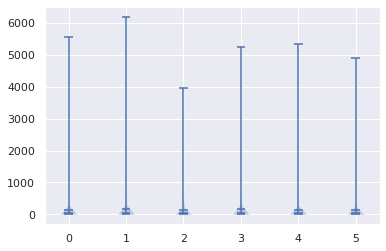

In [50]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]

sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

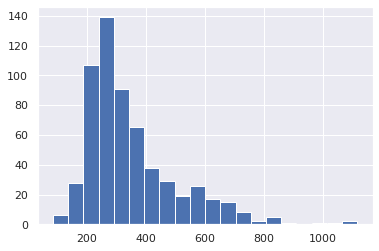

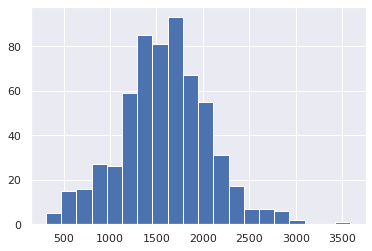

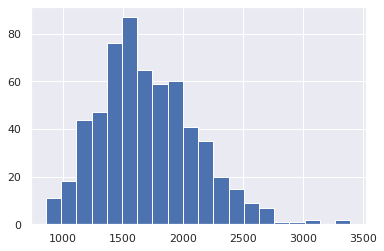

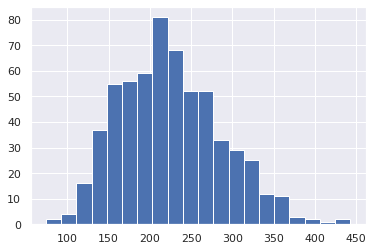

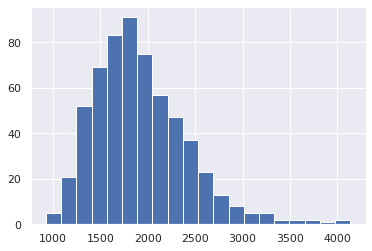

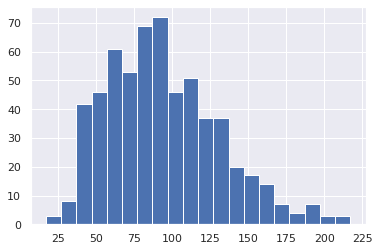

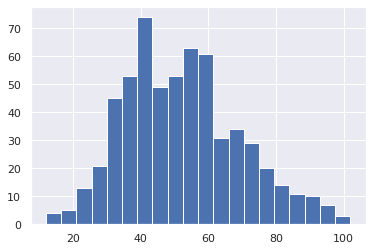

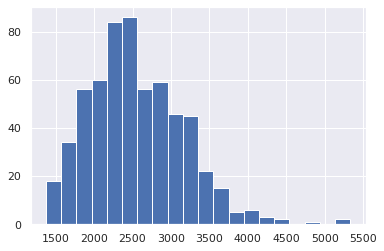

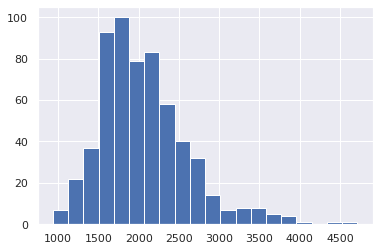

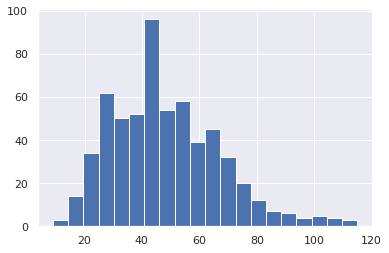

In [51]:
genes = np.random.choice(list(range(D)), p= np.std(data,axis=0)/sum(np.std(data,axis=0)), size=10, replace=False)
for i in range(10):
    plt.hist(data[:,genes[i]], bins=20)
    plt.show()

## Preprocessing

### Transform data

In [52]:
trans_data = np.log2(data+1)

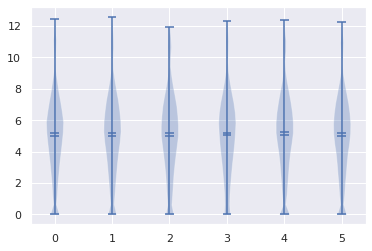

In [53]:
plotdata = [np.concatenate(trans_data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

We remove the genes that are not or barely measured in the dataset to reduce the computational cost.

### Impact of filtering

In [54]:
order = np.argsort(np.std(data, axis=0))
data = data[:,order]

In [65]:
scores = []
rang = np.linspace(0,2,500)
stds = np.std(trans_data, axis=0)
for i in rang:
    scores.append(sum(stds>i))

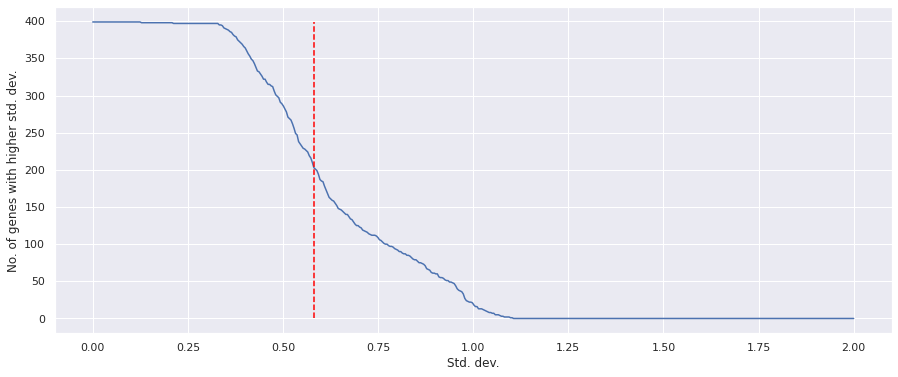

In [71]:
sns.set()
plt.figure(figsize=(15,6))
plt.ylabel('No. of genes with higher std. dev.')
plt.xlabel('Std. dev.')
plt.plot(rang, scores)
plt.plot([rang[145],rang[145]], [0,scores[0]], c = 'red', linestyle='--')
plt.show()

In [70]:
thres = 145
genemask = []
for i in range(D):
    if np.std(trans_data[:,i])>rang[thres]:
        genemask.append(True)
    else:
        genemask.append(False)
genemask = np.array(genemask)
print('Using %i genes with std.dev. of higher than %s'%(int(scores[thres]),str(rang[thres])))

Using 203 genes with std.dev. of higher than 0.5811623246492985


In [72]:
data = trans_data[:,genemask]

238

In [73]:
np.shape(data)

(600, 203)

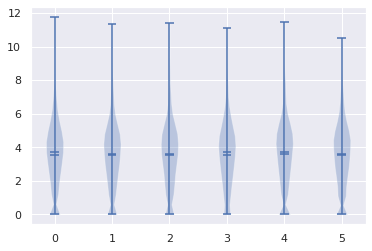

In [74]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

### Loading/Saving  preprocessed data

In [75]:
# with open('smallsplat_prep.pkl', 'wb') as f:
#     pickle.dump([data, labels], f)

In [76]:
data, labels = pickle.load(open('smallsplat_prep.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(600, 203)


### Number of clusters is estimated fairly high

In [84]:
K, _ = est_k(data, k_max = 25, verbose=False, method='bic', refs=3)
print('Estimated number of clusters: ',K)

Estimated number of clusters:  15


### Some classes can be observed

In [81]:
n_test = 6
labels_test = KMeans(n_test).fit(data).labels_

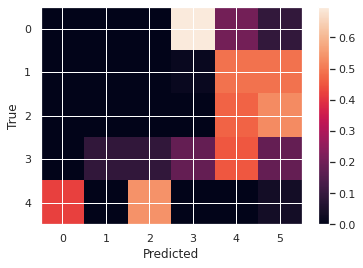

In [82]:
res = np.zeros((5,n_test))
for r in range(5):
    for t in range(n_test):
        res[r,t] = sum(labels[labels_test==t]==r)
    res[r,:] = res[r,:]/sum(res[r,:])
sns.set()
plt.imshow(res, label='Percentage samples')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [83]:
adjusted_rand_score(labels, labels_test)

0.483979716499772

## Analysis

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Latent data on top level:


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Estimated number of clusters (level 0):  2


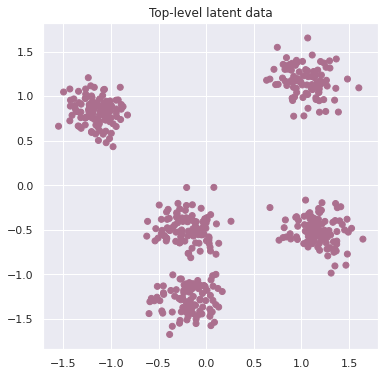

In [ ]:
model = hierarchical_model()
latent, cats_per_lvl, probs = model.fit(data, max_depth=5)

In [13]:
n_subs, subs = est_k(data, k_max = 2, gmm = False, refs = 1, weights=np.ones(465))

In [30]:
model.cats_per_lvl[-1]

array([0, 1, 2, 1, 1, 0, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0,
       2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 0, 0, 1, 0, 2, 2, 2, 1, 0, 0, 1, 1,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 1, 0, 1, 2, 0, 0, 1, 0,
       2, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 3, 1, 1,
       3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 1, 2, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 0,
       2, 0, 2, 1, 3, 2, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 2, 2, 1, 2, 0, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       2, 2, 2, 2, 3, 0, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1,
       2, 1, 2, 0, 1, 1, 1, 3, 2, 0, 1, 1, 1, 1, 2,

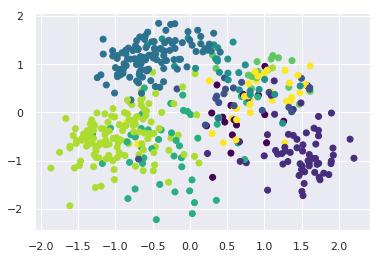

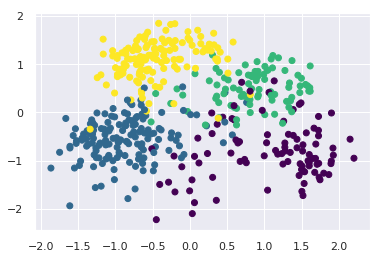

In [32]:
sns.set()
plt.scatter(model.latent[0][0][0,:],model.latent[0][0][1,:], c = labels, cmap='viridis')
plt.show()
plt.scatter(model.latent[0][0][0,:],model.latent[0][0][1,:], c = model.cats_per_lvl[-1], cmap='viridis')
plt.show()